In [14]:
import tensorflow as tf
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from keras.layers import Dense, Flatten, Conv2D, Dropout, Flatten, MaxPool2D, Input, UpSampling2D
from keras import Model
from keras.models import load_model
import numpy as np
from CEM import CEMExplainer
from KC import KerasClassifier
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

tf.get_logger().setLevel(40) 
#tf.compat.v1.disable_v2_behavior() 
from keras import backend as K

import matplotlib
#matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import compat as ct
from utils import model_prediction
from CEM_aen import AEADEN

import matplotlib.image as mpimg
import sys
from PIL import Image

x_train shape: (60000, 28, 28) y_train shape: (60000,)


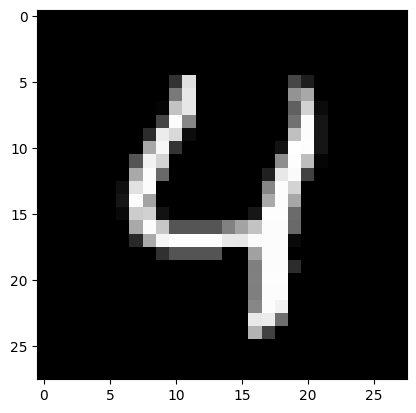

In [3]:
#Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[4]);

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train) #one-hot encoding using to_categorical
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)


In [5]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

Train Model

In [6]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [ ]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(x_train, y_train, epochs=3, batch_size=64, verbose=1)

In [12]:
model.save('mnist.h5', save_format='h5')

In [ ]:
model = load_model('mnist.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

In [ ]:
X = x_test[9].reshape((1,) + x_test[9].shape) #(1,28,28,1)
plt.imshow(X.reshape(28, 28));
model.predict(X).argmax()

Chose an example

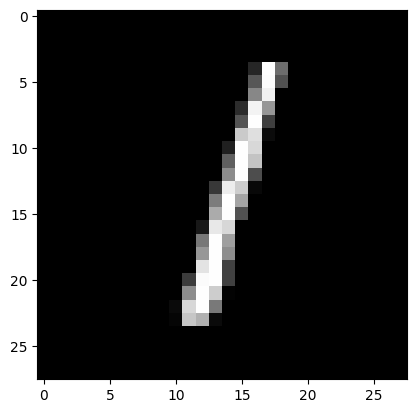

In [10]:
idx = 2
X = x_test[idx].reshape((1,) + x_test[idx].shape) #(1,28,28,1)
plt.imshow(X.reshape(28, 28));


In [ ]:
model.predict(X).argmax(), model.predict(X).max()


Pertinent Negatives

In [12]:
mymodel = KerasClassifier(model)
explainer = CEMExplainer(mymodel)

arg_mode = 'PN' # Find pertinent negatives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 10 # No. of updates to the coefficient of the main loss term
arg_kappa = 0 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = .1 # Controls sparsity of the solution (L1 loss)
arg_gamma = 0 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder
arg_alpha = 0.01 # Penalizes L2 norm of the solution
arg_threshold = 1 # Automatically turn off features <= arg_threshold if arg_threshold < 1
arg_offset = 0.5 # the model assumes classifier trained on data normalized
                # in [-arg_offset, arg_offset] range, where arg_offset is 0 or 0.5


In [ ]:
(adv_pn, delta_pn, info_pn) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma,
                                                            arg_alpha, arg_threshold, arg_offset)

Xpn = adv_pn
classes = [ class_names[np.argmax(model.predict(X))], class_names[np.argmax(model.predict(Xpn))], 'NIL' ]
print("Sample: Mein Beispiel von der 4, die zur 9 wurde")
print("prediction(X)", model.predict(X), class_names[np.argmax(model.predict(X))])
print("prediction(Xpn)", model.predict(Xpn), class_names[np.argmax(model.predict(Xpn))] )


In [ ]:
print("Sample:")
print("prediction(X)", class_names[np.argmax(model.predict(X))])
print("prediction(Xpn)", class_names[np.argmax(model.predict(Xpn))] )

In [15]:
def save_img(img, name = "output.png"):

    np.save(name, img)
    fig = np.around((img + 0.5)*255)
    fig = fig.astype(np.uint8).squeeze()
    pic = Image.fromarray(fig)
    pic.save(name)

In [20]:
orig_class = "8"
adv_class = np.argmax(model.predict(X))
delta_class = np.argmax(model.predict(Xpn))
suffix = "id{}_kappa{}_Orig{}_Adv{}_Delta{}".format(idx, arg_kappa, orig_class, adv_class, delta_class)
os.mkdir("Results/{}_ID{}_Gamma_{}".format(arg_mode, idx, arg_gamma))
arg_save_dir = "{}_ID{}_Gamma_{}".format(arg_mode, idx, arg_gamma)
os.system("mkdir -p Results/{}".format(arg_save_dir))
save_img(X, "Results/{}/Orig_original{}.png".format(arg_save_dir, orig_class))
save_img(adv_pn, "Results/{}/Adv_{}.png".format(arg_save_dir, suffix))
save_img(np.absolute(X-adv_pn)-0.5, "Results/{}/Delta_{}.png".format(arg_save_dir, suffix))

sys.stdout.flush()


Test of the PN

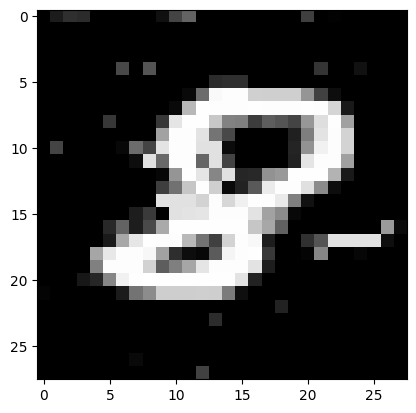

In [43]:
img = mpimg.imread('SpaßVersuch/PN_ID61_Gamma_0/Adv_id61_kappa0_Orig8_Adv8_Delta2.png')
pred = img.reshape((1,)+ img.shape +(1,))
imgplot = plt.imshow(img)


In [45]:
model.predict(pred).argmax()

8

Pertinent Positive

In [16]:
arg_mode = "PP"


arg_mode = 'PP' # Find pertinent positives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.1 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 10.0 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder
arg_alpha = 0.1 # Penalizes L2 norm of the solution
arg_threshold = 0.0 # Automatically turn off features <= arg_threshold if arg_threshold < 1
arg_offset = 0.5 # the model assumes classifier trained on data normalized
                # in [-arg_offset, arg_offset] range, where arg_offset is 0 or 0.5


In [ ]:
(adv_pp, delta_pp, info_pp) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma,
                                                            arg_alpha, arg_threshold, arg_offset)

Xpp = delta_pp
classes = [ class_names[np.argmax(model.predict(X))], class_names[np.argmax(model.predict(Xpp))]]

print("PP for Sample:", idx)
print("Prediction(Xpp) :", class_names[np.argmax(model.predict(Xpp))])
print("Prediction probabilities for Xpp:", model.predict(Xpp))
print("")

In [ ]:
print("Sample:", idx)
print("prediction(X)", class_names[np.argmax(model.predict(X))])
print("prediction(Xpn)", class_names[np.argmax(model.predict(Xpp))] )

In [ ]:
orig_im = x_test[idx].reshape((1,) + x_test[idx].shape) #(1,28,28,1)
plt.imshow(X.reshape(28, 28));

In [209]:
orig_class = "8"
adv_class = np.argmax(model.predict(orig_im))
delta_class = np.argmax(model.predict(Xpp))
suffix = "id{}_kappa{}_Orig{}_Adv{}_Delta{}".format(idx, arg_kappa, orig_class, adv_class, delta_class)
os.mkdir("AEPP/{}_ID{}_Gamma_{}".format(arg_mode, idx, arg_gamma))
arg_save_dir = "{}_ID{}_Gamma_{}".format(arg_mode, idx, arg_gamma)
os.system("mkdir -p AEPP/{}".format(arg_save_dir))
save_img(X, "AEPP/{}/Orig_original{}.png".format(arg_save_dir, orig_class))
save_img(adv_pp, "AEPP/{}/Adv_{}.png".format(arg_save_dir, suffix))
save_img(np.absolute(X-adv_pp)-0.5, "AEPP/{}/Delta_{}.png".format(arg_save_dir, suffix))

sys.stdout.flush()


Test of the PP

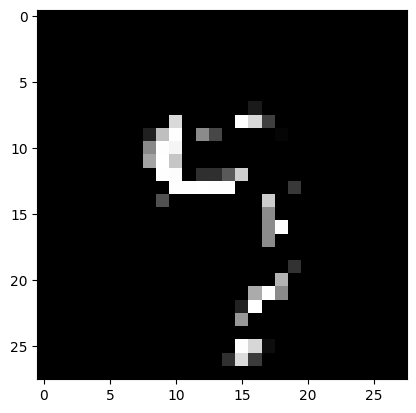

In [35]:
img = mpimg.imread('AE/PP_ID616_Gamma_100/Delta_id616_kappa0.1_Orig8_Adv4_Delta9.png')
plt.gray()
imgplot = plt.imshow(img)
pred = img.reshape((1,)+ img.shape +(1,))

In [36]:
model.predict(pred).argmax()

4

In [21]:
os.remove('mnist.h5')